
# HMM - 2. deo

In [1]:
import numpy as np

# Bezbedno izračunavanje sume logaritmovanih vrednosti
from scipy.special import logsumexp

In [2]:
class HMM:
    # Inicijalizacija HMM, Lambda (L) je uređena trojka 
    # matrica funkcija raspodela P, A i B
    def __init__(self, L):
        (P, A, B) = L
        self.A = A
        self.B = B
        self.P = P
        
    # Funkcija raspodele verovatnoća prelazaka,
    # a(q_1, q) -> verovatnoća prelaska iz stanja q-1 u stanje q
    def a(self, q_1, q):
        return self.A[q_1][q]
    
    # Funkcija raspodele emisionih verovatnoća,
    # b(q, x) -> verovatnoća emisija simbola x iz stanja q
    def b(self, q, x):
        return self.B[q][x]
    
    # Funkcija raspodele emisionih verovatnoća,
    # p(q) -> verovatnoća početka HMM iz stanja q
    def p(self, q):
        return self.P[q]
    
    # Prevođenje rednog broja stanja u oznaku stanja,
    # npr 0 -> 'A'
    def decode_state(self, i):
        return list(self.P.keys())[i]
    
    # Prevođenje oznake stanja u redni broj,
    # npr 'A' -> 0
    def encode_state(self, q):
        return list(self.P.keys()).index(q)
    
    # Treniranje parametara HMM na osnovu trening sekvenci X
    # labeliranih oznakama Y
    def fit(self, X, Y):
        P = {}
        n = len(X)
        
        q_set = set([])
        x_set = set([])
        
        for y in Y:
            for q in y:
                q_set.add(q)
                
        for x in X:
            for x_j in x:
                x_set.add(x_j)
        
        # P
        # ---------
        for q in q_set:
            P[q] = 0
            
        self.P = P
        
        n = len(Y)
        for y in Y:
            q_0 = y[0]
            P[q_0] += 1 / n
        
        # B
        # ---------
        B = {}
        
        for q in q_set:
            B[q] = {}
            for x_j in x_set:
                B[q][x_j] = 1
        
        for t in range(n):
            x = X[t]
            y = Y[t]
            for j in range(len(x)):
                q = y[j]
                B[q][x[j]] += 1
                
        
        for q in q_set:
            total_count = 0
            for x_j, count in B[q].items():
                total_count += count
                
            for x_j in B[q].keys():
                B[q][x_j] /= total_count
        
        # A
        # ---------
        A = {}
        
        state_counts = [2 for _ in q_set] # 1 za A, 1 za B, kod P(A|B)
        for y in Y:
            for i in range(len(y) - 1):
                q = y[i]
                state_counts[self.encode_state(q)] += 1
                
                
        # Pseudobrojaci
        for q_1 in q_set:
            A[q_1] = {}
            for q in q_set:
                A[q_1][q] = 1 / state_counts[self.encode_state(q_1)]
                
        print(state_counts)

        for y in Y:
            for i in range(1, len(y)):
                q_1 = y[i-1]
                q = y[i]
                
                A[q_1][q] += 1 / state_counts[self.encode_state(q_1)]

        self.A = A
        self.B = B
        self.P = P
    
    # Viterbi algoritam za pronalaženje najverovatnije sekvence
    # skrivenih stanja iz kojih je emitovana sekvenca x
    def viterbi(self, x):
        T = len(x)
        N = len(self.P.keys())
        
        v = np.array([[0.0 for _ in range(T)] for _ in range(N)])
        backtrack = np.array([[0 for _ in range(T)] for _ in range(N)])
        
        for j in range(T):
            x_j = x[j]
            
            # Analiza početnog stanja
            if j == 0:
                for i in range(N):
                    q = self.decode_state(i)
                    transition_prob = np.log(self.p(q))
                    
                    emission_prob = np.log(self.b(q, x_j))
                    
                    v[i, j] = transition_prob + emission_prob
                    backtrack[i, j] = -1
                    
            else:
                for i in range(N):
                    q = self.decode_state(i)
                    emission_prob = np.log(self.b(q, x_j))
                    
                    max_prob = float('-inf')
                    max_prev_i = None
                    
                    for i_1 in range(N):
                        q_1 = self.decode_state(i_1)
                        
                        previous_prob = v[i_1, j - 1]
                        transition_prob = np.log(self.a(q_1, q))
                        
                        prob = previous_prob + transition_prob + emission_prob
                        
                        if prob > max_prob:
                            max_prob = prob
                            max_prev_i = i_1
                            
                    v[i, j] = max_prob
                    backtrack[i, j] = max_prev_i
                    
        i = np.argmax(v[:, T - 1])
        qn = self.decode_state(i)
        
        path = [qn]
    
        j = T - 1
        
        # Rekonstrukcija puta
        while backtrack[i][j] != -1:
            i = backtrack[i][j]
            qi = self.decode_state(i)
            path = [qi] + path
            j -= 1
            
        return path
    
    # Forward algoritam za izračunavanje verovatnoće
    # prefiksa sekvence do pozicije k
    def forward(self, X, k = None):
        if k == None:
            T = len(X)
        else:
            T = k
        
        N = len(self.A)

        v_matrix = np.array([[0.0 for _ in range(T)] for _ in range(N)])
        
        for t in range(T):
            x = X[t]
            
            if t == 0:
                for i in range(N):
                    q = self.decode_state(i)
                    
                    transition_prob = self.p(q)
                    emission_prob = self.b(q, x)
                    
                    prob = transition_prob * emission_prob
                    
                    v_matrix[i,t] = prob
                    
            else:
                for i in range(N):

                    sum_prob = 0

                    q = self.decode_state(i)

                    emission_prob = self.b(q, x)

                    for j in range(N):
                        q_1 = self.decode_state(j)

                        prev_prob = v_matrix[j, t - 1]

                        transition_prob = self.a(q_1, q)

                        prob = transition_prob * emission_prob * prev_prob

                        sum_prob += prob

                    v_matrix[i, t] = sum_prob
                
        
        return v_matrix[:,T - 1].sum(), v_matrix[:,T - 1], v_matrix
    
    
    # Backward algoritam za izračunavanje verovatnoće
    # sufiksa sekvence od pozicije k
    def backward(self, X, k = None):
        T = len(X)
        N = len(self.A)
        
        if k == None:
            start = 0
        else:
            start = k

        v_matrix = np.array([[0.0 for _ in range(T)] for _ in range(N)])
  
        for t in reversed(range(start, T)):
            x = X[t]
            
            if t == T - 1:
                for i in range(N):
                    q = self.decode_state(i)
                    
                    transition_prob = 1
                    emission_prob = self.b(q, x)
                    
                    prob = transition_prob * emission_prob
                    
                    v_matrix[i, t] = prob
                    
            else:
                for i in range(N):

                    sum_prob = 0

                    q = self.decode_state(i)

                    emission_prob = self.b(q, x)

                    for j in range(N):
                        q_1 = self.decode_state(j)

                        prev_prob = v_matrix[j, t + 1]

                        transition_prob = self.a(q, q_1)

                        prob = transition_prob * emission_prob * prev_prob
                        
                        if t == start:
                            prob *= self.p(q)

                        
                        sum_prob += prob

                    v_matrix[i, t] = sum_prob
        
        return v_matrix[:,start].sum(), v_matrix[:,start], v_matrix
    
    # Forward-backward algoritam za izračunavanje raspodele verovatnoća
    # dolaska u skrivena stanja modela u trenutku t
    def forward_backward(self, X, t):
        _, alpha, _ = self.forward(X, t)
        _, beta, _ = self.backward(X, t)
        prod = (alpha * beta)
        norm_prod = prod / prod.sum()
        
        return norm_prod
    
    # Primer implementacije backward algoritma
    # koji koristi logaritme verovatnoća
    def log_backward(self, X, k = None):
        T = len(X)
        N = len(self.A)
        
        if k == None:
            start = 0
        else:
            start = k

        v_matrix = np.array([[0.0 for _ in range(T)] for _ in range(N)])
  
        for t in reversed(range(start, T)):
            x = X[t]
            
            if t == T - 1:
                for i in range(N):
                    q = self.decode_state(i)
                    
                    transition_prob = 0
                    emission_prob = np.log(self.b(q, x))
                    
                    prob = transition_prob + emission_prob
                    
                    v_matrix[i, t] = prob
                    
            else:
                for i in range(N):

                    sum_prob = None

                    q = self.decode_state(i)

                    emission_prob = np.log(self.b(q, x))

                    for j in range(N):
                        q_1 = self.decode_state(j)

                        prev_prob = v_matrix[j, t + 1]

                        transition_prob = np.log(self.a(q, q_1))

                        prob = transition_prob + emission_prob + prev_prob
                        
                        if t == start:
                            prob += np.log(self.p(q))

                        if sum_prob == None:
                            sum_prob = prob
                        else:
                            sum_prob = logsumexp([sum_prob, prob])

                    v_matrix[i, t] = sum_prob
        
        return logsumexp(v_matrix[:,start]), v_matrix[:,start], v_matrix
    
    # Baum-Welch algoritam za učenje parametara HMM,
    # EM pristupom, na pojedinačnoj sekvenci
    def baum_welch_single_sequence(self, X):
        _, _, all_alpha = self.forward(X)
        _, _, all_beta = self.backward(X)
        
        T = len(X)
        N = len(self.A)
        
        gamma = all_alpha * all_beta
        
        for t in range(T):
            marg_prob = gamma[:, t].sum()
            gamma[:, t] /= marg_prob
            
        zeye = np.array([[[0.0 for t in range(T)] for j in range(N)] for i in range(N)])
        
        for t in range(T - 1):
            marg_prob = 0
            for i in range(N):
                qi = self.decode_state(i)
                
                for j in range(N):
                    qj = self.decode_state(j)
                    
                    prob = all_alpha[i, t] * self.a(qi, qj) * all_beta[j, t + 1] * self.b(qj, X[t + 1])
                    zeye[i, j, t] = prob
                    marg_prob += prob
                    
            zeye[:,:,t] /= marg_prob
            
        new_P = {}
        
        for i in range(N):
            qi = self.decode_state(i)
            
            new_P[qi] = gamma[i, 0]
            
        new_a = {}
        
        for i in range(N):
            qi = self.decode_state(i)
            
            if qi not in new_a:
                new_a[qi] = {}
            
            for j in range(N):
                qj = self.decode_state(j)
                
                new_a[qi][qj] = zeye[i,j, : T - 1].sum() / gamma[i, : T - 1].sum()
                
        v = ['A','T', 'C', 'G']
        
        new_b = {}
        
        for i in range(N):
            qi = self.decode_state(i)
            new_b[qi] = {}
            
            for vk in v:
                indicator = np.array([int(X[t] == vk) for t in range(T)])
                
                new_b[qi][vk] = (gamma[i,:] * indicator).sum() / gamma[i,:].sum()
            
            
        return new_a, new_b, new_P
    
    # Metod izračunava verovatnoću pojave
    # kompletne sekvence X_arr pri zadatim
    # parametrima HMM
    def x_prob(self, X_arr):
        total_prob = 1.0
        
        for x in X_arr:
            total_prob *= self.forward(x)[0]
            
        return total_prob
    
    # Baum-Welch algoritam za učenje parametara HMM
    # nad skupom trening sekvenci
    def baum_welch(self, X_arr):
        R = len(X_arr)
        N = len(self.A)
        
        eps = pow(10, -10)
            
        old_prob = 0
        new_prob = 1
        
        v = ['A','T','C','G']
        
        while True:
            old_prob = self.x_prob(X)
            
            a = []
            b = []
            p = []
            
            for x in X_arr:
                ai, bi, pi = self.baum_welch_single_sequence(x)
                a.append(ai)
                b.append(bi)
                p.append(pi)
                
            new_P = {}
            new_A = {}
            new_B = {}
                
            for r in range(R):
                # P
                for i in range(N):
                    qi = self.decode_state(i)
                    
                    if qi not in new_P:
                        new_P[qi] = 0
                        
                    new_P[qi] += (p[r][qi] / R)
                    
                # A
                for i in range(N):
                    qi = self.decode_state(i)
                    for j in range(N):
                        qj = self.decode_state(j)

                        if qi not in new_A:
                            new_A[qi] = {}
                            
                        if qj not in new_A[qi]:
                            new_A[qi][qj] = 0

                        new_A[qi][qj] += (a[r][qi][qj] / R)
                        
                # B
                for i in range(N):
                    qi = self.decode_state(i)
                    for vk in v:

                        if qi not in new_B:
                            new_B[qi] = {}
                            
                        if vk not in new_B[qi]:
                            new_B[qi][vk] = 0

                        new_B[qi][vk] += (b[r][qi][vk] / R)
                

            self.A = new_A
            self.P = new_P
            self.B = new_B
                
            new_prob = self.x_prob(X)
            
            if new_prob <= old_prob + eps:
                break

In [3]:
# Funkcija raspodele početnih verovatnoća
P = {
    '-': 0.5,
    '+': 0.5
}

# Funkcija raspodele verovatnoća prelaza između stanja
A = {
    '-': {
        '-': 0.6,
        '+': 0.4
        },
    '+': {
        '-': 0.4,
        '+': 0.6
    }
}

# Funkcija raspodele emisionih verovatnoća
B = {
    '-': {
        'A': 0.30,
        'C': 0.25,
        'G': 0.20,
        'T': 0.25
    },
    '+': {
        'A': 0.20,
        'C': 0.25,
        'G': 0.30,
        'T': 0.25
    }
}

## Primeri

In [4]:
hmm = HMM((P, A, B))

In [5]:
seq = 'CACACACA'
hmm.forward(seq)

(1.53340625e-05,
 array([9.2615625e-06, 6.0725000e-06]),
 array([[1.2500000e-01, 3.7500000e-02, 8.1250000e-03, 2.3625000e-03,
         5.0937500e-04, 1.4793750e-04, 3.1890625e-05, 9.2615625e-06],
        [1.2500000e-01, 2.5000000e-02, 7.5000000e-03, 1.5500000e-03,
         4.6875000e-04, 9.7000000e-05, 2.9343750e-05, 6.0725000e-06]]))

In [6]:
seq = 'CACACACA'
hmm.backward(seq)

(1.53340625e-05,
 array([7.9859375e-06, 7.3481250e-06]),
 array([[7.9859375e-06, 7.4092500e-05, 2.5512500e-04, 1.1835000e-03,
         4.0750000e-03, 1.8900000e-02, 6.5000000e-02, 3.0000000e-01],
        [7.3481250e-06, 4.8580000e-05, 2.3475000e-04, 7.7600000e-04,
         3.7500000e-03, 1.2400000e-02, 6.0000000e-02, 2.0000000e-01]]))

In [7]:
seq = 'GCCGTAAT'
hmm.forward_backward(seq, t=2)

array([0.46097561, 0.53902439])

In [8]:
X = 'ATATCATTGCGCGTTCGCGAGCTATTTTATATATCTAGAGTAGCAGAGGCGCGCATATAGCTACTATCGT'
hmm.baum_welch_single_sequence(X)

({'-': {'-': 0.5970536739631223, '+': 0.3981790031535128},
  '+': {'-': 0.4082225205915375, '+': 0.5966822194047895}},
 {'-': {'A': 0.34737042962954334,
   'T': 0.3195685397429177,
   'C': 0.19146885088188303,
   'G': 0.14159217974565544},
  '+': {'A': 0.1644573608387282,
   'T': 0.30885897735935797,
   'C': 0.2087635494147188,
   'G': 0.3179201123871953}},
 {'-': 0.6957313201406969, '+': 0.3042686798593031})

Učenje parametara modela na osnovu trening sekvenci X

In [9]:
X = ['ATTATATTATATTATATTAAA', 'CCTAGTCGTGTCGCAAAAAAAACTGCTCTGACCTGAGC', 'ATTATATGCCGCGGC', 'GGGCCCCGGCTTATATAT']
Y = ['---------------------', '++++++++++++++--------++++++++++++++++', '-------++++++++', '++++++++++--------']

hmm.baum_welch(X)

print(hmm.P)
print(hmm.A)
print(hmm.B)

{'-': 0.5436104561661537, '+': 0.45638954383384633}
{'-': {'-': 0.612879858514279, '+': 0.3778108930191608}, '+': {'-': 0.42477483545209105, '+': 0.5927173059087132}}
{'-': {'A': 0.36886476053343237, 'T': 0.31125613140564523, 'C': 0.20492752425819916, 'G': 0.11495158380272327}, '+': {'A': 0.18842629287121224, 'T': 0.3395303275277183, 'C': 0.2122486373364868, 'G': 0.25979474226458266}}


Evaluacija treniranog modela nad trening sekvencama u odnosu na stvarne oznake skrivenih stanja

In [10]:
for i in range(len(X)):
    x = X[i]
    y = Y[i]
    
    print(x)
    print(''.join(hmm.viterbi(x)))
    print(y)

ATTATATTATATTATATTAAA
---------------------
---------------------
CCTAGTCGTGTCGCAAAAAAAACTGCTCTGACCTGAGC
----++++++++++--------++++++++++++++++
++++++++++++++--------++++++++++++++++
ATTATATGCCGCGGC
------+++++++++
-------++++++++
GGGCCCCGGCTTATATAT
++++++++++++------
++++++++++--------


# Biblioteka HMMLearn

In [11]:
from hmmlearn import hmm
import numpy as np

In [12]:
# Konstrukcija modela za pronalaženje CpG ostrva
model = hmm.MultinomialHMM(n_components=2)

In [13]:
# 0: -, 1: +
states = ['-', '+']
observations = ['A', 'C', 'G', 'T']
#                            -     +
model.startprob_ = np.array([0.5, 0.5])
model.transmat_ = np.array([
    # --   -+
    [0.9, 0.1],
    
    # +-   ++
    [0.1, 0.9]
])
model.emissionprob_ = np.array([
    # A      C     G     T
    [0.37, 0.13, 0.13, 0.37],
    [0.13, 0.37, 0.37, 0.13],
])

X = 'ATATCATTGCGCGTTCGCGAGCTATTTTATATATCTAGAGTAGCAGAGGCGCGCATATAGCTACTATCGT'
X_encoded = []

for x in X:
    X_encoded.append(observations.index(x))
    
X_encoded = np.array([X_encoded]).T

In [14]:
# Kodiranje emisija u brojeve
encoded_y = model.decode(X_encoded)[1]
y_pred = ''.join(list(map(lambda y: states[y], encoded_y)))

In [15]:
print(X)
print(y_pred)

ATATCATTGCGCGTTCGCGAGCTATTTTATATATCTAGAGTAGCAGAGGCGCGCATATAGCTACTATCGT
--------++++++++++++++--------------------++++++++++++----------------


Učenje parametara modela

In [49]:
new_model = hmm.MultinomialHMM(n_components=2, algorithm='viterbi')

X = ['ATTATATTATATTATATTAAA', 'CCTAGTCGTGTCGCAAAAAAAACTGCTCTGACCTGAGC', 'ATTATATGCCGCGGC', 'GGGCCCCGGCTTATATAT']
X_encoded = None
init = False
for x in X:
    new_encoded = []
    for c in x:
        new_encoded.append(observations.index(c))
        
    
    if not init:
        X_encoded = np.array([new_encoded]).T
        init = True
    else:
        X_encoded = np.concatenate([X_encoded, np.array([new_encoded]).T])
    
X_encoded


new_model.fit(X_encoded, [len(x) for x in X])

MultinomialHMM(n_components=2, random_state=RandomState(MT19937) at 0x107CF6540)

In [50]:
X = 'ATATCATTGCGCGTTCGCGAGCTATTTTATATATCTAGAGTAGCAGAGGCGCGCATATAGCTACTATCGT'
X_encoded = []

for x in X:
    X_encoded.append(observations.index(x))
    
X_encoded = np.array([X_encoded]).T

# new_model.decode(X_encoded)

encoded_y = new_model.decode(X_encoded)[1]
y_pred = ''.join(list(map(lambda y: states[y], encoded_y)))

In [51]:
''' 
Napomena, algoritam za učenje parametara HMM modela
pronalazi lokalno optimalno rešenje te je moguće da 
pronađeni parametri (posebno u ovako jednostavnom slučaju)
značajno odstupaju od očekivanih, te je potrebno obuku
pokrenuti više puta
'''

print(X)
print(y_pred)

ATATCATTGCGCGTTCGCGAGCTATTTTATATATCTAGAGTAGCAGAGGCGCGCATATAGCTACTATCGT
----++++++++++++++++++------------++++++++++++++++++++-----+++++++++++


## Primer: segmentisanje EKG signala

In [19]:
import wfdb
import matplotlib.pyplot as plt

In [20]:
# Izvor: https://physionet.org/
sample = wfdb.rdsamp('data/a01')

In [21]:
signal = sample[0]

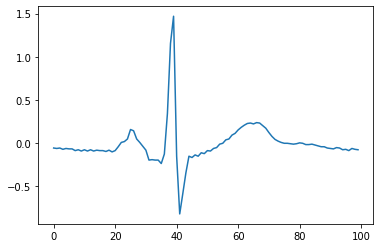

In [22]:
signal_short = signal.ravel()[:100]

plt.plot(signal_short)

In [23]:
# Pronalaženje modela koji na signalu prepoznaje
# 4 komponente

n_components = 4
ghmm_model = hmm.GaussianHMM(n_components = n_components)
ghmm_model.fit(signal)

GaussianHMM(n_components=4)

In [65]:
y_pred = ghmm_model.decode(signal[:300])

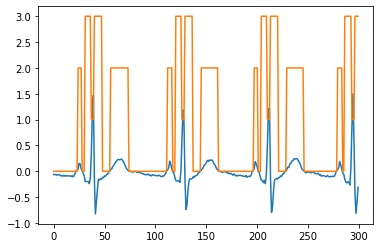

In [66]:
plt.plot(signal[:300].ravel())
plt.plot(y_pred[1].ravel())

Generisanje novih uzoraka pomoću HMM

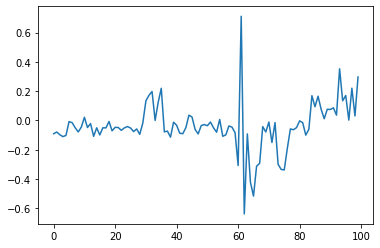

In [127]:
samples = ghmm_model.sample(n_samples=100)
plt.plot(samples[0].ravel())